In [1]:
from minlsh import MinHashLSHiForest
import data_loader
import numpy as np
from sklearn.metrics import roc_auc_score
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# CIC
X_train, y_train, X_test, y_test, y_cat = data_loader.load_cic_for_minhash() # とりあえず20000件だけ読み込み
y_true = np.array([0 if label == "Benign" else 1 for label in y_test])
print(f"X_train size is {len(X_train)}")
print(f"X_test size is {len(X_test)}")
print(X_train.head())

X_train size is 667626
X_test size is 20000


In [4]:
# LSHiForestのインスタンス化と学習
lshif = MinHashLSHiForest(n_estimators=100, sample_size=256, eta=1.0)
start = time.time()
lshif.fit(X_train)
stop = time.time()
print(f"Trained Time: {stop -start}")

# 異常スコアの計算
start = time.time()
scores = lshif.decision_function(X_test)
stop = time.time()

# 2. AUCスコアを計算
print(f"Executed Time: {stop-start}")
auc_scores = roc_auc_score(y_true, scores)
print(f"AUC Score: {auc_scores}")

Trained Time: 0.846381664276123
Executed Time: 14.331114053726196
AUC Score: 0.3206974410436528


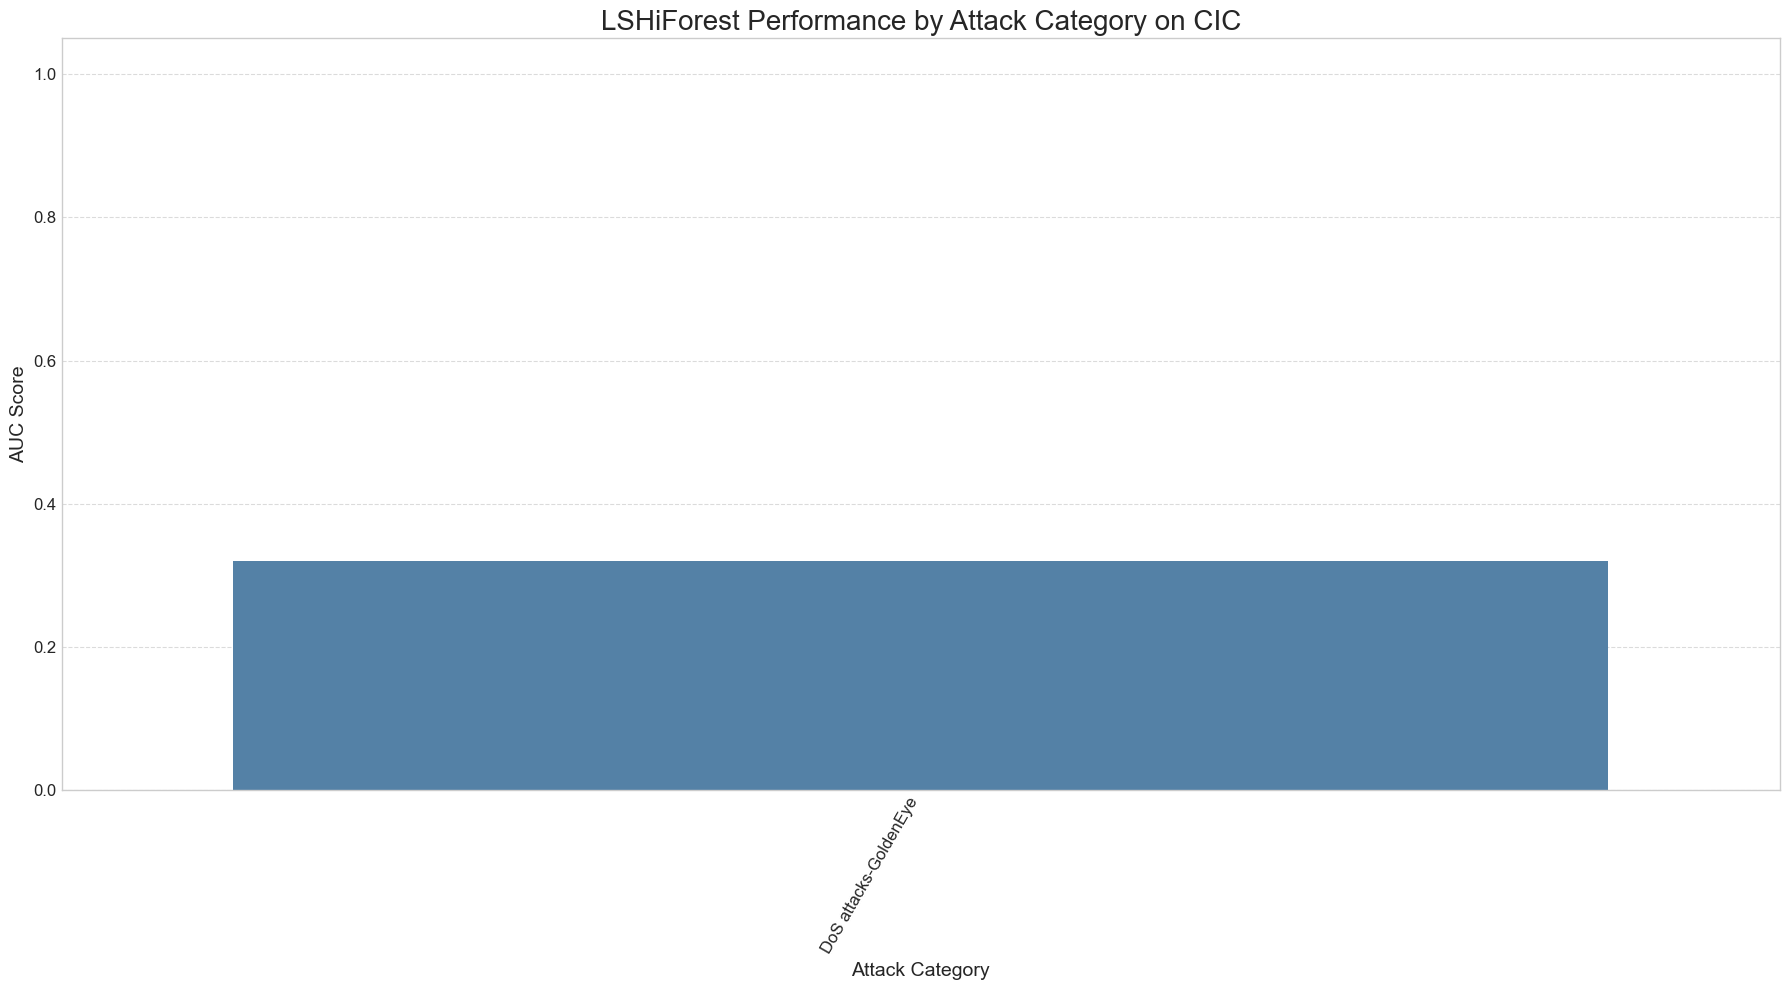

AUC Scores (Each Attack Category vs. Normal Traffic):
         Attack Category  AUC Score
0  DoS attacks-GoldenEye   0.320697


In [6]:
# 結果の描写
results_df = pd.DataFrame({
    'attack_cat': y_test,
    'label': [0 if label == 'Benign' else 1 for label in y_test],
    'score': scores
})

# 2. 正常データと攻撃データを分離
normal_df = results_df[results_df['label'] == 0]
attack_df = results_df[results_df['label'] == 1]

# 3. 各攻撃カテゴリのAUCスコアを計算
auc_scores_by_cat = {}
unique_attack_cats = sorted(attack_df['attack_cat'].unique())

for cat in unique_attack_cats:
    current_attack_df = attack_df[attack_df['attack_cat'] == cat]
    eval_df = pd.concat([normal_df, current_attack_df])
    auc = roc_auc_score(eval_df['label'], eval_df['score'])
    auc_scores_by_cat[cat] = auc

plot_df = pd.DataFrame(list(auc_scores_by_cat.items()), columns=['Attack Category', 'AUC Score'])
plot_df = plot_df.sort_values('AUC Score', ascending=False)
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(18, 10))
sns.barplot(data=plot_df, x='Attack Category', y='AUC Score', color='steelblue', ax=ax)
ax.set_title('LSHiForest Performance by Attack Category on CIC', fontsize=20)
ax.set_xlabel('Attack Category', fontsize=14)
ax.set_ylabel('AUC Score', fontsize=14)
ax.set_ylim(0, 1.05)
ax.tick_params(axis='x', labelsize=12) 
plt.setp(ax.get_xticklabels(), rotation=60, ha='right')
ax.tick_params(axis='y', labelsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print("AUC Scores (Each Attack Category vs. Normal Traffic):")
print(plot_df)

In [ ]:
# unswの実験
print("Results of UNSW:")
X_train, y_train, X_test, y_test, y_cat = data_loader.load_unsw_for_minhash()
print(f"X_train size is {len(X_train)}")
print(f"X_test size is {len(X_test)}")

Results of UNSW:
X_train size is 56000
X_test size is 82332


0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

In [3]:
# LSHiForestのインスタンス化と学習
lshif = MinHashLSHiForest(n_estimators=100, sample_size=256, eta=1.0)
start = time.time()
lshif.fit(X_train)
stop = time.time()
print(f"Trained Time: {stop -start}")

# 異常スコアの計算
start = time.time()
scores = lshif.decision_function(X_test)
stop = time.time()

# 2. AUCスコアを計算
print(f"Executed Time: {stop - start}")
auc_score = roc_auc_score(y_test, scores)
print(f"AUC Score: {auc_score}")

Trained Time: 0.619041919708252
Executed Time: 31.667321920394897
AUC Score: 0.7921603112531926


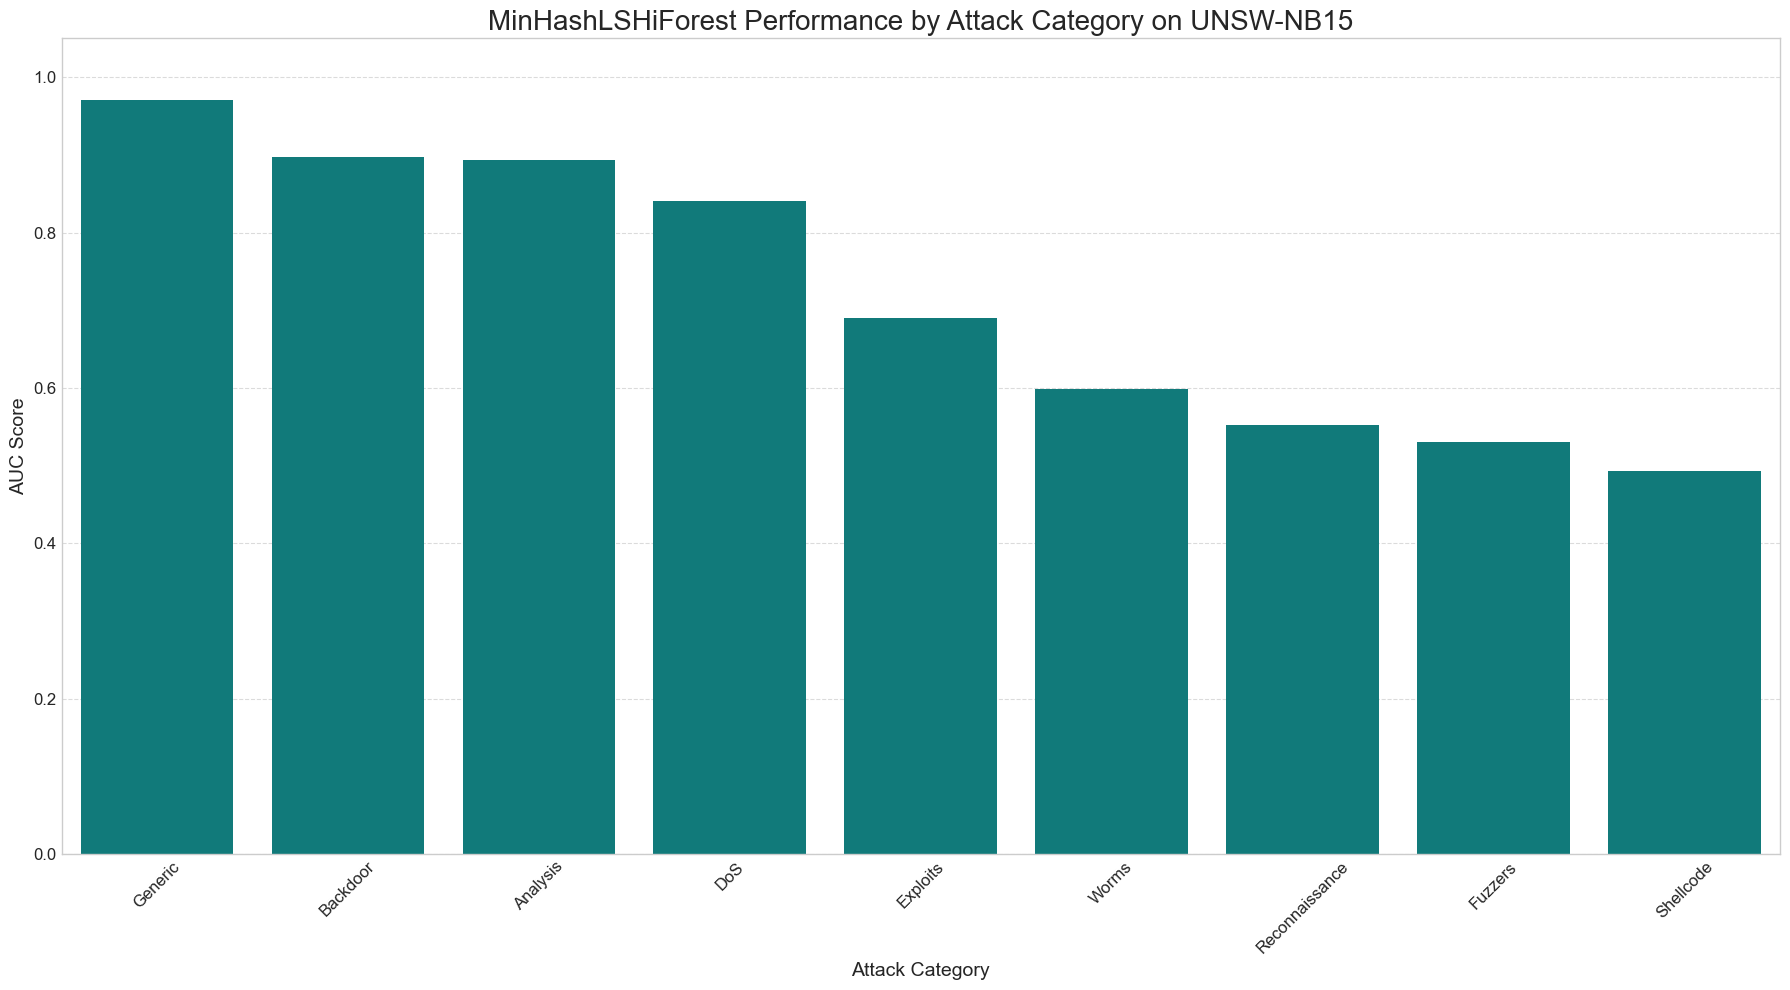

AUC Scores (Each Attack Category vs. Normal Traffic):
  Attack Category  AUC Score
5         Generic   0.970245
1        Backdoor   0.896932
0        Analysis   0.893685
2             DoS   0.840455
3        Exploits   0.689687
8           Worms   0.598410
6  Reconnaissance   0.552878
4         Fuzzers   0.530016
7       Shellcode   0.493158


In [4]:
# 攻撃別手法分析
results_df = pd.DataFrame({
    'attack_cat': y_cat,
    'label': y_test,
    'score': scores 
})

# 2. 正常データと攻撃データを分離
normal_df = results_df[results_df['label'] == 0]
attack_df = results_df[results_df['label'] == 1]

# 3. 各攻撃カテゴリのAUCスコアを計算
auc_scores_by_cat = {}
unique_attack_cats = sorted(attack_df['attack_cat'].unique())

for cat in unique_attack_cats:
    
    current_attack_df = attack_df[attack_df['attack_cat'] == cat]
    eval_df = pd.concat([normal_df, current_attack_df])
    auc = roc_auc_score(eval_df['label'], eval_df['score'])
    auc_scores_by_cat[cat] = auc

# --- 4. グラフの描画 -
plot_df = pd.DataFrame(list(auc_scores_by_cat.items()), columns=['Attack Category', 'AUC Score'])
plot_df = plot_df.sort_values('AUC Score', ascending=False)
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(18, 10))
sns.barplot(data=plot_df, x='Attack Category', y='AUC Score', color='darkcyan', ax=ax)
ax.set_title('MinHashLSHiForest Performance by Attack Category on UNSW-NB15', fontsize=20)
ax.set_xlabel('Attack Category', fontsize=14)
ax.set_ylabel('AUC Score', fontsize=14)
ax.set_ylim(0, 1.05)
ax.tick_params(axis='x', labelrotation=45, labelsize=12) 
ax.tick_params(axis='y', labelsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print("AUC Scores (Each Attack Category vs. Normal Traffic):")
print(plot_df.to_string())

In [5]:
# NSL
X_train, y_train, X_test, y_test = data_loader.load_nsl_for_minhash()
y_true = np.array([0 if label == "normal" else 1 for label in y_test])
print(f"X_train size is {len(X_train)}")
print(f"X_test size is {len(X_test)}")

# LSHiForestのインスタンス化と学習
lshif = MinHashLSHiForest(n_estimators=100, sample_size=256, eta=1.0)
start = time.time()
lshif.fit(X_train)
stop = time.time()
print(f"Trained Time: {stop -start}")

# 異常スコアの計算
start = time.time()
scores = lshif.decision_function(X_test)
stop = time.time()

# 2. AUCスコアを計算
print(f"Executed Time: {stop-start}")
auc_scores = roc_auc_score(y_true, scores)
print(f"AUC Score: {auc_scores}")

X_train size is 67343
X_test size is 22544
Trained Time: 0.6571629047393799
Executed Time: 11.850467205047607
AUC Score: 0.9358305291770314


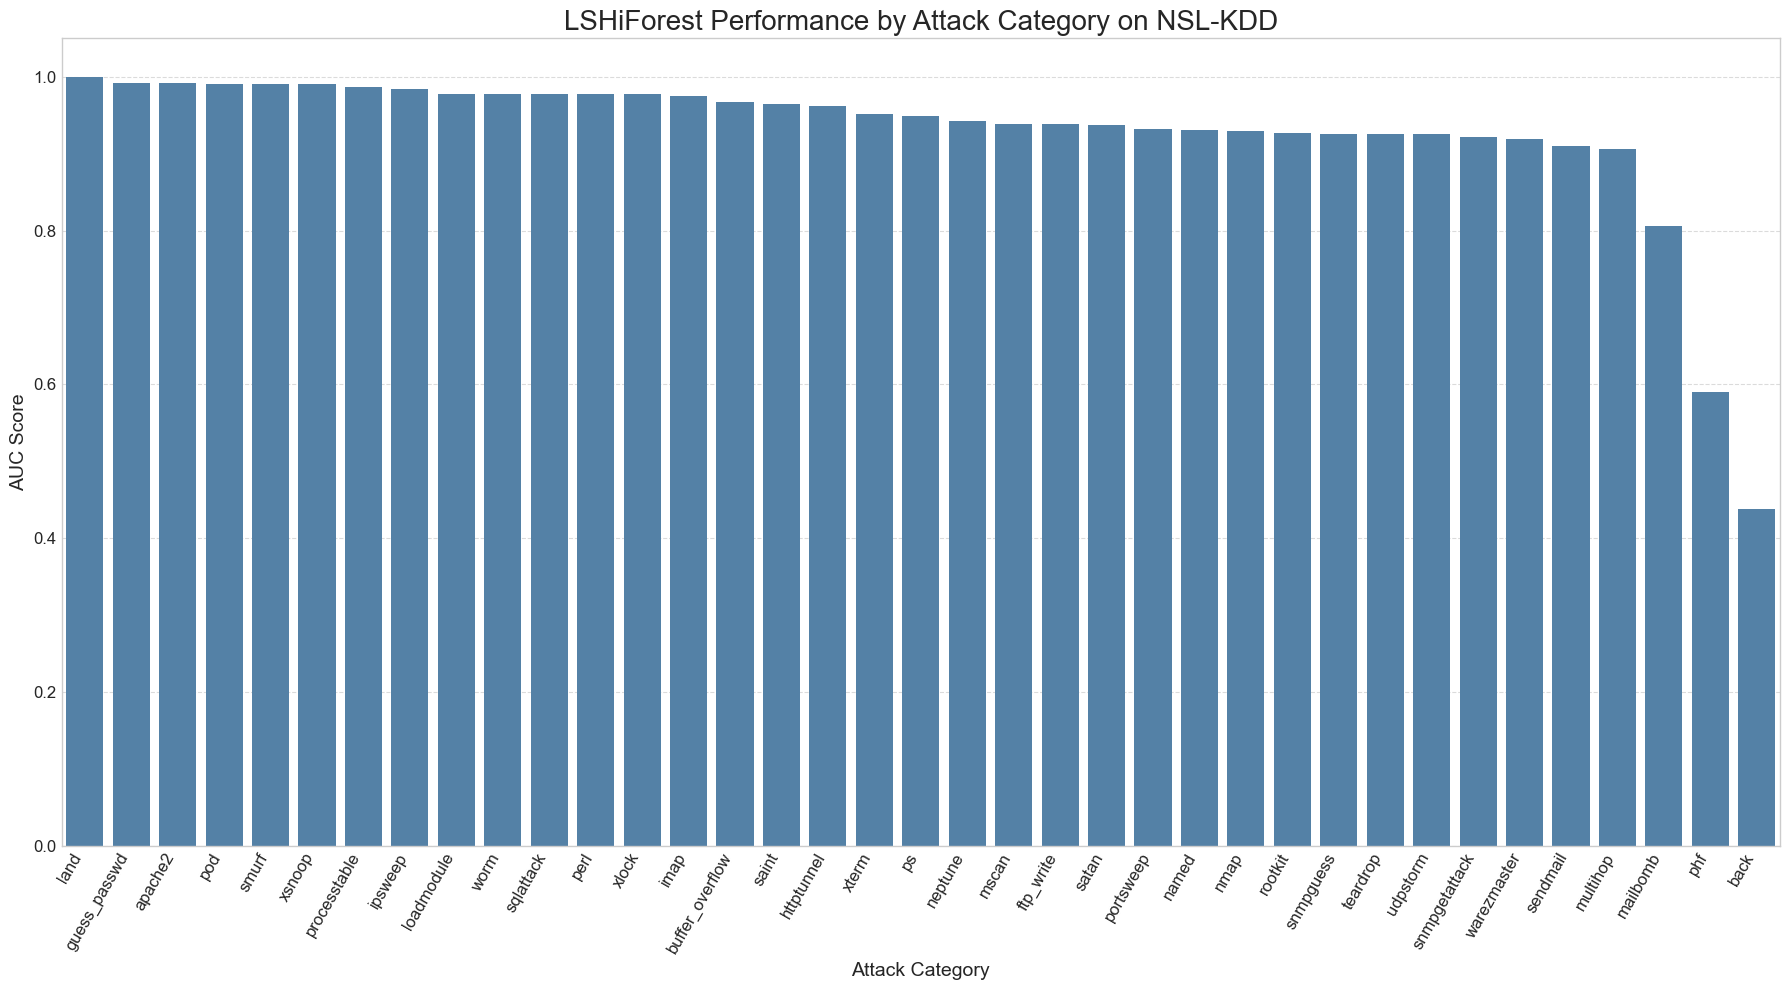

AUC Scores (Each Attack Category vs. Normal Traffic):
    Attack Category  AUC Score
8              land   1.000000
4      guess_passwd   0.992450
0           apache2   0.991646
18              pod   0.990937
26            smurf   0.990629
35           xsnoop   0.990166
20     processtable   0.986292
7           ipsweep   0.983726
9        loadmodule   0.978066
33             worm   0.978066
29        sqlattack   0.978066
16             perl   0.978066
34            xlock   0.977328
6              imap   0.975183
2   buffer_overflow   0.966703
23            saint   0.964138
5        httptunnel   0.961871
36            xterm   0.952215
21               ps   0.949700
14          neptune   0.942617
11            mscan   0.938296
3         ftp_write   0.938266
24            satan   0.937105
19        portsweep   0.931629
13            named   0.931406
15             nmap   0.929554
22          rootkit   0.927109
28        snmpguess   0.926204
30         teardrop   0.925703
31         udpst

In [6]:
# 結果の描写
results_df = pd.DataFrame({
    'attack_cat': y_test,
    'label': [0 if label == 'normal' else 1 for label in y_test],
    'score': scores
})

# 2. 正常データと攻撃データを分離
normal_df = results_df[results_df['label'] == 0]
attack_df = results_df[results_df['label'] == 1]

# 3. 各攻撃カテゴリのAUCスコアを計算
auc_scores_by_cat = {}
unique_attack_cats = sorted(attack_df['attack_cat'].unique())

for cat in unique_attack_cats:
    current_attack_df = attack_df[attack_df['attack_cat'] == cat]
    eval_df = pd.concat([normal_df, current_attack_df])
    auc = roc_auc_score(eval_df['label'], eval_df['score'])
    auc_scores_by_cat[cat] = auc

plot_df = pd.DataFrame(list(auc_scores_by_cat.items()), columns=['Attack Category', 'AUC Score'])
plot_df = plot_df.sort_values('AUC Score', ascending=False)
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(18, 10))
sns.barplot(data=plot_df, x='Attack Category', y='AUC Score', color='steelblue', ax=ax)
ax.set_title('LSHiForest Performance by Attack Category on NSL-KDD', fontsize=20)
ax.set_xlabel('Attack Category', fontsize=14)
ax.set_ylabel('AUC Score', fontsize=14)
ax.set_ylim(0, 1.05)
ax.tick_params(axis='x', labelsize=12) 
plt.setp(ax.get_xticklabels(), rotation=60, ha='right')
ax.tick_params(axis='y', labelsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print("AUC Scores (Each Attack Category vs. Normal Traffic):")
print(plot_df)

In [7]:
# unswでbinningした数値特徴量とカテゴリ値で実験
X_train, y_train, X_test, y_test, y_cat = data_loader.load_unsw_binned()
print(f"X_train size is {len(X_train)}")
print(f"X_test size is {len(X_test)}")
X_train.head()

X_train size is 56000
X_test size is 82332


0    {proto:tcp, pca_3:1, is_ftp_login:0, pca_4:1, ...
1    {proto:tcp, is_ftp_login:0, pca_4:1, state:FIN...
2    {proto:tcp, pca_3:1, is_ftp_login:0, pca_4:1, ...
3    {proto:tcp, pca_3:1, pca_4:1, service:ftp, sta...
4    {pca_3:4, proto:tcp, pca_5:4, pca_1:2, is_ftp_...
dtype: object

In [8]:
# LSHiForestのインスタンス化と学習
lshif = MinHashLSHiForest(n_estimators=100, sample_size=256, eta=1.0)
start = time.time()
lshif.fit(X_train)
stop = time.time()
print(f"Trained Time: {stop -start}")

# 異常スコアの計算
start = time.time()
scores = lshif.decision_function(X_test)
stop = time.time()

# 2. AUCスコアを計算
print(f"Executed Time: {stop - start}")
auc_score = roc_auc_score(y_test, scores)
print(f"AUC Score: {auc_score}")

Trained Time: 0.8740551471710205
Executed Time: 73.17944812774658
AUC Score: 0.7512861918434803


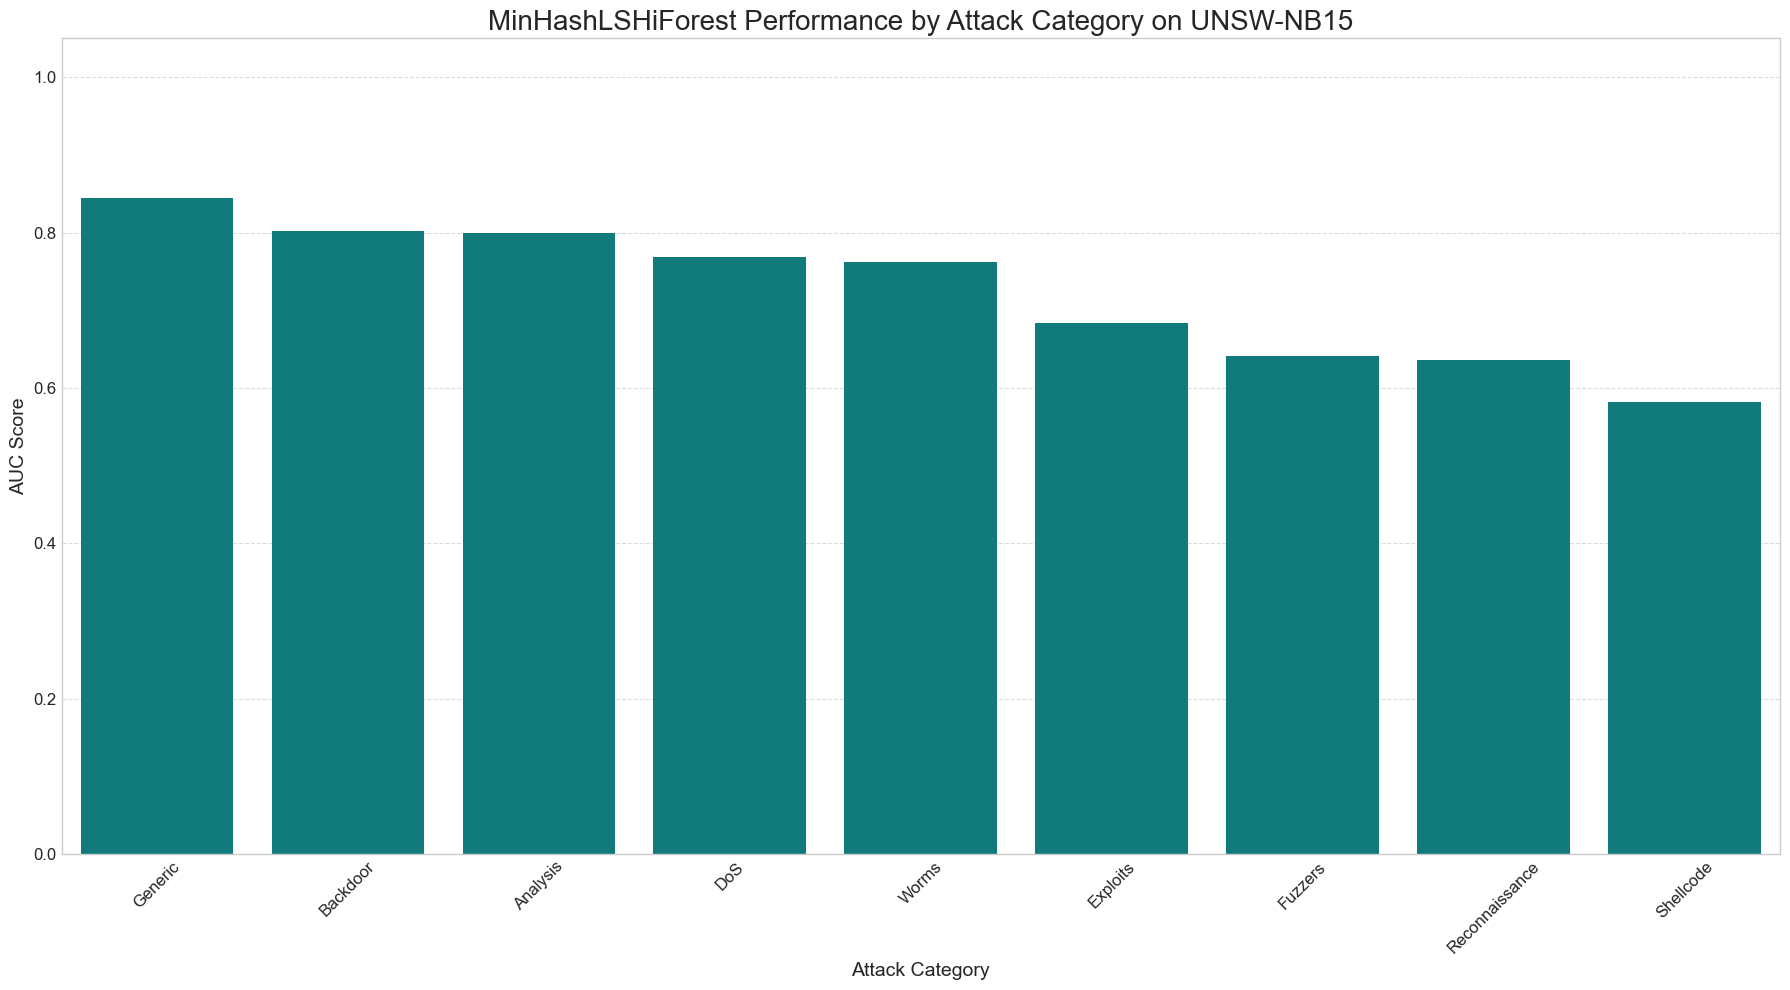

AUC Scores (Each Attack Category vs. Normal Traffic):
  Attack Category  AUC Score
5         Generic   0.844123
1        Backdoor   0.802821
0        Analysis   0.799940
2             DoS   0.768785
8           Worms   0.762613
3        Exploits   0.683837
4         Fuzzers   0.640673
6  Reconnaissance   0.636448
7       Shellcode   0.581696


In [9]:
# 攻撃別手法分析
results_df = pd.DataFrame({
    'attack_cat': y_cat,
    'label': y_test,
    'score': scores  # セル2で計算した異常度スコア
})

# 2. 正常データと攻撃データを分離
normal_df = results_df[results_df['label'] == 0]
attack_df = results_df[results_df['label'] == 1]

# 3. 各攻撃カテゴリのAUCスコアを計算
auc_scores_by_cat = {}
unique_attack_cats = sorted(attack_df['attack_cat'].unique())

for cat in unique_attack_cats:
    
    current_attack_df = attack_df[attack_df['attack_cat'] == cat]
    eval_df = pd.concat([normal_df, current_attack_df])
    auc = roc_auc_score(eval_df['label'], eval_df['score'])
    auc_scores_by_cat[cat] = auc

# --- 4. グラフの描画 -
plot_df = pd.DataFrame(list(auc_scores_by_cat.items()), columns=['Attack Category', 'AUC Score'])
plot_df = plot_df.sort_values('AUC Score', ascending=False)
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(18, 10))
sns.barplot(data=plot_df, x='Attack Category', y='AUC Score', color='darkcyan', ax=ax)
ax.set_title('MinHashLSHiForest Performance by Attack Category on UNSW-NB15', fontsize=20)
ax.set_xlabel('Attack Category', fontsize=14)
ax.set_ylabel('AUC Score', fontsize=14)
ax.set_ylim(0, 1.05)
ax.tick_params(axis='x', labelrotation=45, labelsize=12) # X軸ラベルを回転
ax.tick_params(axis='y', labelsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print("AUC Scores (Each Attack Category vs. Normal Traffic):")
print(plot_df.to_string())

In [10]:
# NSL
X_train, y_train, X_test, y_test = data_loader.load_nsl_binned()
y_true = np.array([0 if label == "normal" else 1 for label in y_test])
print(f"X_train size is {len(X_train)}")
print(f"X_test size is {len(X_test)}")

# LSHiForestのインスタンス化と学習
lshif = MinHashLSHiForest(n_estimators=100, sample_size=256, eta=1.0)
start = time.time()
lshif.fit(X_train)
stop = time.time()
print(f"Trained Time: {stop -start}")

# 異常スコアの計算
start = time.time()
scores = lshif.decision_function(X_test)
stop = time.time()

# 2. AUCスコアを計算
print(f"Executed Time: {stop-start}")
auc_scores = roc_auc_score(y_true, scores)
print(f"AUC Score: {auc_scores}")

X_train size is 67343
X_test size is 22544
Trained Time: 0.9353101253509521
Executed Time: 19.20170497894287
AUC Score: 0.9385271917842782


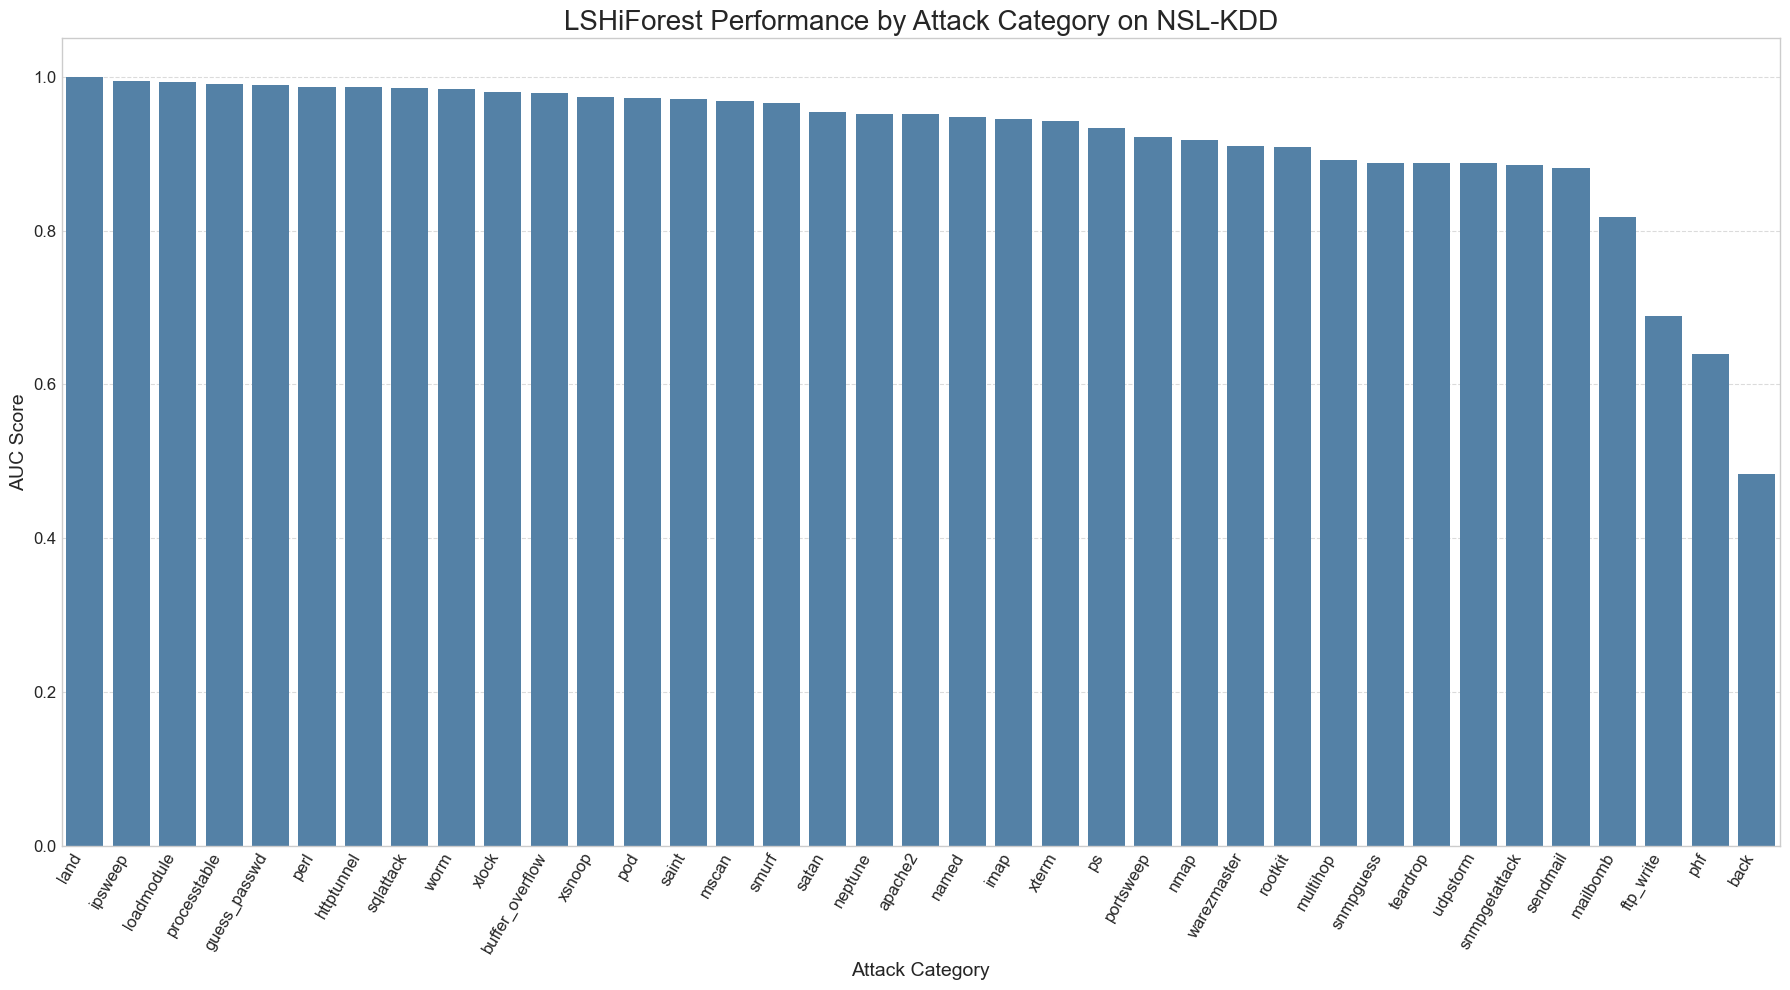

AUC Scores (Each Attack Category vs. Normal Traffic):
    Attack Category  AUC Score
8              land   1.000000
7           ipsweep   0.994729
9        loadmodule   0.993023
20     processtable   0.991297
4      guess_passwd   0.988937
16             perl   0.987257
5        httptunnel   0.987162
29        sqlattack   0.984966
33             worm   0.983781
34            xlock   0.980360
2   buffer_overflow   0.978723
35           xsnoop   0.973831
18              pod   0.972818
23            saint   0.971643
11            mscan   0.969230
26            smurf   0.966609
24            satan   0.954144
14          neptune   0.951955
0           apache2   0.951522
13            named   0.948303
6              imap   0.944805
36            xterm   0.942104
21               ps   0.934137
19        portsweep   0.921553
15             nmap   0.918246
32      warezmaster   0.910392
22          rootkit   0.908977
12         multihop   0.891724
28        snmpguess   0.887967
30         teard

In [11]:
results_df = pd.DataFrame({
    'attack_cat': y_test,
    'label': [0 if label == 'normal' else 1 for label in y_test],
    'score': scores
})

normal_df = results_df[results_df['label'] == 0]
attack_df = results_df[results_df['label'] == 1]
auc_scores_by_cat = {}
unique_attack_cats = sorted(attack_df['attack_cat'].unique())

for cat in unique_attack_cats:
    current_attack_df = attack_df[attack_df['attack_cat'] == cat]
    eval_df = pd.concat([normal_df, current_attack_df])
    auc = roc_auc_score(eval_df['label'], eval_df['score'])
    auc_scores_by_cat[cat] = auc

plot_df = pd.DataFrame(list(auc_scores_by_cat.items()), columns=['Attack Category', 'AUC Score'])
plot_df = plot_df.sort_values('AUC Score', ascending=False)
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(18, 10))
sns.barplot(data=plot_df, x='Attack Category', y='AUC Score', color='steelblue', ax=ax)
ax.set_title('LSHiForest Performance by Attack Category on NSL-KDD', fontsize=20)
ax.set_xlabel('Attack Category', fontsize=14)
ax.set_ylabel('AUC Score', fontsize=14)
ax.set_ylim(0, 1.05)
ax.tick_params(axis='x', labelsize=12) 
plt.setp(ax.get_xticklabels(), rotation=60, ha='right')
ax.tick_params(axis='y', labelsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print("AUC Scores (Each Attack Category vs. Normal Traffic):")
print(plot_df)